In [7]:
#Baseline model
#naive bayes
import pandas as pd
def to_seuqnce_data(X_train, X_test, max_length):
    tokenizer = Tokenizer()
    X = X_train + X_test
    tokenizer.fit_on_texts(X)
    word_index_items = tokenizer.word_index.items()
    vocab_size = len(tokenizer.word_index) + 1
    word_seq_train = tokenizer.texts_to_sequences(X_train)
    word_seq_test = tokenizer.texts_to_sequences(X_test)
    X_train_seq = sequence.pad_sequences(word_seq_train, maxlen=max_length)
    X_test_seq = sequence.pad_sequences(word_seq_test, maxlen=max_length)
    
    return X_train_seq, X_test_seq, vocab_size, word_index_items

df_dir = pd.read_csv("/work/tadesse/beichen/Tweets_DIR/Data/DIR/DIR_processed.csv")

In [8]:
text = df_dir.processed_title.values
labels = df_dir.iloc[:,-9:-2].values
x_train = text[:9925]#70%
y_train = labels[:9925,:]
x_test = text[9925:]#30%
y_test = labels[9925:,:]

In [9]:
x_test

array(['Fire dangersred flag warnings occurring in Alamosa County Colorado',
       'Dust Storm Warning and grass fires causing burn ban in Rooks County Kansas',
       'Burn ban extended in Ector County Texas', ...,
       'Herd of mule deer living in Alamosa Colorado since 2002 drought',
       'Water scarcity taught lettuce growers in Yuma Arizona how to increase water efficiency',
       'Drought among factors leading shippers to abandon the Missouri River'],
      dtype=object)

In [10]:
import nltk
import re
from bs4 import BeautifulSoup
import unicodedata
from nltk.tokenize.toktok import ToktokTokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
#convert the text into sequence vector, the max length is 64
max_length = 64
tokenizer = Tokenizer()
X_preprocessed = np.array([])
X_preprocessed = np.append(X_preprocessed, x_train)
X_preprocessed = np.append(X_preprocessed, x_test)
tokenizer.fit_on_texts(X_preprocessed)
vocab_size = len(tokenizer.word_index) + 1
word_index_items = tokenizer.word_index.items()
word_seq_train = tokenizer.texts_to_sequences(x_train)
word_seq_test = tokenizer.texts_to_sequences(x_test)
x_train_seq = sequence.pad_sequences(word_seq_train, maxlen=max_length)
x_test_seq = sequence.pad_sequences(word_seq_test, maxlen=max_length)

In [11]:
vocab_size

9269

In [27]:
def load_pretrained_embedding(fdir = "/work/tadesse/beichen/csce879/Homework_CSCE879/hw2/glove.840B.300d.txt"):
    #load the pretrained word embedding model from the txt file
    from tqdm import tqdm
    import codecs
    import numpy as np
    embeddings_index = {}
    f = codecs.open(fdir, encoding="utf-8")
    for line in tqdm(f):
        values = line.rstrip().rsplit(' ')
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
    f.close()
    print('Done!')
    return embeddings_index

In [28]:
embeddings_index = load_pretrained_embedding()

2196018it [04:11, 8738.07it/s]

Done!


In [39]:
print('Loaded %s word vectors.' % len(embeddings_index))

Loaded 2196016 word vectors.


In [41]:
# create a weight matrix for words in training docs
embedding_matrix = np.zeros((vocab_size, 300))
for word, i in word_index_items:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [12]:
# Define a pipeline combining a text feature extractor with multi lable classifier
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
NB_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(stop_words=stop_words)),
                ('clf', OneVsRestClassifier(MultinomialNB(
                    fit_prior=True, class_prior=None))),
            ])
category_idx = ['Agriculture', 'Economy', 'Fire', 'Plants & Wildlife', 
                    'Relief, Response & Restrictions', 'Society & Public Health', 'Water Supply & Quality']
for i in range(0,7):
    print('... Processing {}'.format(category_idx[i]))
    # train the model using X_dtm & y
    NB_pipeline.fit(x_train, y_train[:,i])
    # compute the testing accuracy
    prediction = NB_pipeline.predict(x_test)
    print('Test accuracy is {}'.format(accuracy_score(y_test[:,i], prediction)))

... Processing Agriculture
Test accuracy is 0.894897719256995
... Processing Economy
Test accuracy is 0.8946625911121562
... Processing Fire
Test accuracy is 0.9130025864095932
... Processing Plants & Wildlife
Test accuracy is 0.8227133787914414
... Processing Relief, Response & Restrictions
Test accuracy is 0.8927815659534446
... Processing Society & Public Health
Test accuracy is 0.8521043968963085
... Processing Water Supply & Quality
Test accuracy is 0.8008464613214201


In [53]:
from sklearn.model_selection import StratifiedKFold
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
import nltk
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
import pandas as pd
import seaborn as sns
from wordcloud import WordCloud
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import LayerNormalization
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import GRU
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import GlobalMaxPooling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Model
from tensorflow.keras.layers import Input
from attention import Attention
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import LayerNormalization
import itertools

In [68]:
#buid RNN models
def def_model_wPooling(vocab_size, word_index, embeddings_index,vector_size = 300, layer_norm = True, global_pooling = True):
    pretrain_embedding = True
    words = Input(shape=(None,))
    #Word attention
    # We'll make a conv layer to produce the query and value tensors
    query_layer = tf.keras.layers.Conv1D(
        filters=100,
        kernel_size=4,
        padding='same')
    value_layer = tf.keras.layers.Conv1D(
        filters=100,
        kernel_size=4,
        padding='same')
    # Then they will be input to the Attention layer
    attention = tf.keras.layers.Attention()
    concat = tf.keras.layers.Concatenate()
    
    # add pretrained word embedding models (or not)
    if pretrain_embedding:
        # create a weight matrix for words in training docs
        embedding_matrix = np.zeros((vocab_size, vector_size))
        for word, i in word_index:
            embedding_vector = embeddings_index.get(word)
            if embedding_vector is not None:
                embedding_matrix[i] = embedding_vector
        embeddings = Embedding(vocab_size, vector_size, weights=[embedding_matrix], trainable=False)(words)
    else:
        embeddings = Embedding(vocab_size,vector_size,trainable=True)(words)
    #query = query_layer(embeddings)
    #value = value_layer(embeddings)
    #query_value_attention = attention([query, value])
    #attended_values = concat([query, query_value_attention])
    '''
    #Bidrection LSTM
    X = Bidirectional(LSTM(100, activation='tanh', return_sequences=True))(attended_values)
    X = Bidirectional(LSTM(100, activation='tanh', return_sequences=True))(X)
    if global_pooling:
        X = Bidirectional(LSTM(100, activation='tanh', return_sequences=True,dropout=0.2))(X)
        X = GlobalMaxPooling1D()(X)
    else:
        X = Bidirectional(LSTM(100, activation='tanh', dropout=0.2))(X)
    '''
    '''
    #GRU
    X = GRU(100, activation='tanh', return_sequences=True)(attended_values)
    X = GRU(100, activation='tanh', return_sequences=True)(X)
    '''
    X = LSTM(100, activation='tanh')(embeddings)
    X = Dense(128,activation='relu')(X)
    results = Dense(7,activation='sigmoid')(X)
    opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
    model = Model(inputs=words, outputs=[results])
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    
    return model
model = def_model_wPooling(vocab_size = vocab_size, word_index = word_index_items, embeddings_index = embeddings_index, layer_norm = True, global_pooling = True)

In [69]:
model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding_8 (Embedding)      (None, None, 300)         2780700   
_________________________________________________________________
lstm_4 (LSTM)                (None, 100)               160400    
_________________________________________________________________
dense_8 (Dense)              (None, 128)               12928     
_________________________________________________________________
dense_9 (Dense)              (None, 7)                 903       
Total params: 2,954,931
Trainable params: 174,231
Non-trainable params: 2,780,700
_________________________________________________________________


In [70]:
from tensorflow.keras.callbacks import EarlyStopping
checkpoint_path = "./training_checkpoints"
es_callback = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience = 5)
cp_callback = ModelCheckpoint(filepath=checkpoint_path, save_weights_only=True, verbose=0, save_freq='epoch')

In [71]:
from skmultilearn.model_selection import IterativeStratification
kfold = IterativeStratification(n_splits=5, order=1) #5-fold varification
cvscores = [] #cross validation score
for train, test in kfold.split(x_train_seq, y_train):
    #define the model within the 5-fold loop. Because we don't want to use the cross
    #validation to re-train a same model
    model = def_model_wPooling(vocab_size = vocab_size, word_index = word_index_items, 
                               embeddings_index = embeddings_index, layer_norm = True, global_pooling = True)
    #fit the model
    history = model.fit(tf.gather(x_train_seq,train), tf.gather(y_train,train), batch_size=100, epochs=30, 
                        validation_split=0.2,
                    callbacks=[es_callback,cp_callback],verbose=1,shuffle=True)
    # evaluate the model
    scores = model.evaluate(tf.gather(x_train_seq,test), tf.gather(y_train,test), verbose=0)
    print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
    cvscores.append(scores[1] * 100)

Epoch 1/30
64/64 [==============================] - 7s 78ms/step - loss: 0.6668 - accuracy: 0.2474 - val_loss: 0.5358 - val_accuracy: 0.4425
Epoch 2/30
64/64 [==============================] - 4s 70ms/step - loss: 0.5365 - accuracy: 0.4641 - val_loss: 0.4735 - val_accuracy: 0.4375
Epoch 3/30
64/64 [==============================] - 4s 70ms/step - loss: 0.4617 - accuracy: 0.4697 - val_loss: 0.4026 - val_accuracy: 0.5016
Epoch 4/30
64/64 [==============================] - 5s 70ms/step - loss: 0.4083 - accuracy: 0.5457 - val_loss: 0.3453 - val_accuracy: 0.6656
Epoch 5/30
64/64 [==============================] - 4s 70ms/step - loss: 0.3641 - accuracy: 0.6015 - val_loss: 0.3086 - val_accuracy: 0.7184
Epoch 6/30
64/64 [==============================] - 4s 70ms/step - loss: 0.3330 - accuracy: 0.6174 - val_loss: 0.3013 - val_accuracy: 0.7228
Epoch 7/30
64/64 [==============================] - 4s 70ms/step - loss: 0.3168 - accuracy: 0.6454 - val_loss: 0.2894 - val_accuracy: 0.7341
Epoch 8/30
64

In [72]:
def plot_diagnostics(history):
    #plot loss curve
    plt.figure()
    plt.plot(history.history['loss'], color='blue', label='train')
    plt.plot(history.history['val_loss'], color='red', label='validation')
    plt.xlabel('Epoch')
    plt.legend()
    plt.title('Cross Entropy Loss')
    plt.savefig('loss_curve.png')
    #plot accuracy curve
    plt.figure()
    plt.plot(history.history['accuracy'], color='blue', label='train')
    plt.plot(history.history['val_accuracy'], color='red', label='validation')
    plt.xlabel('Epoch')
    plt.legend()
    plt.title('Classification Accuracy')
    plt.savefig('accu_curve.png')

69.58% (+/- 1.28%)
Accuracy on the test set: 89.245%


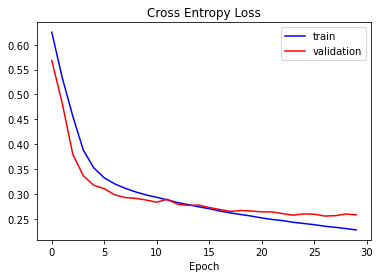

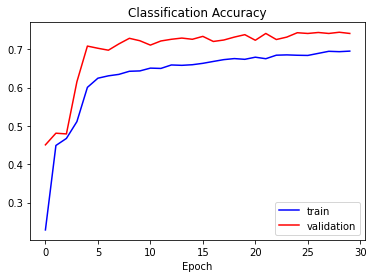

In [88]:
print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))


#plot learning curves
plot_diagnostics(history)


#prediction
predict =  model.predict(x_test_seq)
predict[predict>=0.5] = 1
predict[predict<0.5] = 0
label = predict
count = 0
for i in range(label.shape[0]):
    if sum(y_test[i,:] == label[i,:].astype("int")) == 7:
        count += 1
pred_acc = count/label.shape[0]
print('Accuracy on the test set: %.3f%%' % (pred_accu*100))

In [ ]:
for i in range(7):
    accu = sum(label[:,i] == y_test[i,:])/label.shape[0]
    print(category_idx[i])
    print('Test accuracy is {}'.format(accu))